# Exploratory Data Analysis - MercadoLibre New vs Used Classification

This notebook provides a comprehensive analysis of the features available in the MercadoLibre dataset before any transformation, to identify which features would be most valuable for the classification task.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Overview

In [24]:
# Load the data
data = []
with open('MLA_100k.jsonlines', 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (100000, 48)
Columns: ['seller_address', 'warranty', 'sub_status', 'condition', 'seller_contact', 'deal_ids', 'base_price', 'shipping', 'non_mercado_pago_payment_methods', 'seller_id', 'variations', 'location', 'site_id', 'listing_type_id', 'price', 'attributes', 'buying_mode', 'tags', 'listing_source', 'parent_item_id', 'coverage_areas', 'category_id', 'descriptions', 'last_updated', 'international_delivery_mode', 'pictures', 'id', 'official_store_id', 'differential_pricing', 'accepts_mercadopago', 'original_price', 'currency_id', 'thumbnail', 'title', 'automatic_relist', 'date_created', 'secure_thumbnail', 'stop_time', 'status', 'video_id', 'catalog_product_id', 'subtitle', 'initial_quantity', 'start_time', 'permalink', 'geolocation', 'sold_quantity', 'available_quantity']

First few rows:


,seller_address,warranty,sub_status,condition,seller_contact,deal_ids,base_price,shipping,non_mercado_pago_payment_methods,seller_id,...,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,geolocation,sold_quantity,available_quantity
0,"{'comment': '', 'longitude': -58.3986709, 'id'...",None,[],new,None,[],80.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",74952096,...,active,None,NaN,None,1,2015-09-05T20:42:53.000Z,http://articulo.mercadolibre.com.ar/MLA-578052...,"{'latitude': -34.6280698, 'longitude': -58.398...",0,1
1,"{'comment': '', 'longitude': -58.5059173, 'id'...",NUESTRA REPUTACION,[],used,None,[],2650.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",42093335,...,active,None,NaN,None,1,2015-09-26T18:08:30.000Z,http://articulo.mercadolibre.com.ar/MLA-581565...,"{'latitude': -34.5935524, 'longitude': -58.505...",0,1
2,"{'comment': '', 'longitude': -58.4143948, 'id'...",None,[],used,None,[],60.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",133384258,...,active,None,NaN,None,1,2015-09-09T23:57:07.000Z,http://articulo.mercadolibre.com.ar/MLA-578780...,"{'latitude': -34.6233907, 'longitude': -58.414...",0,1
3,"{'comment': '', 'longitude': -58.4929208, 'id'...",None,[],new,None,[],580.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",143001605,...,active,None,NaN,None,1,2015-09-28T18:47:56.000Z,http://articulo.mercadolibre.com.ar/MLA-581877...,"{'latitude': -34.6281894, 'longitude': -58.492...",0,1
4,"{'comment': '', 'longitude': -58.5495042, 'id'...",MI REPUTACION.,[],used,None,[],30.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",96873449,...,active,None,NaN,None,1,2015-08-24T22:07:20.000Z,http://articulo.mercadolibre.com.ar/MLA-576112...,"{'latitude': -34.6346547, 'longitude': -58.549...",0,1


## 2. Target Variable Analysis

=== TARGET VARIABLE ANALYSIS ===
Target column: condition
Unique values: ['new' 'used']
Value counts:
condition
new     53758
used    46242
Name: count, dtype: int64
Class balance: condition
new     0.53758
used    0.46242
Name: proportion, dtype: float64


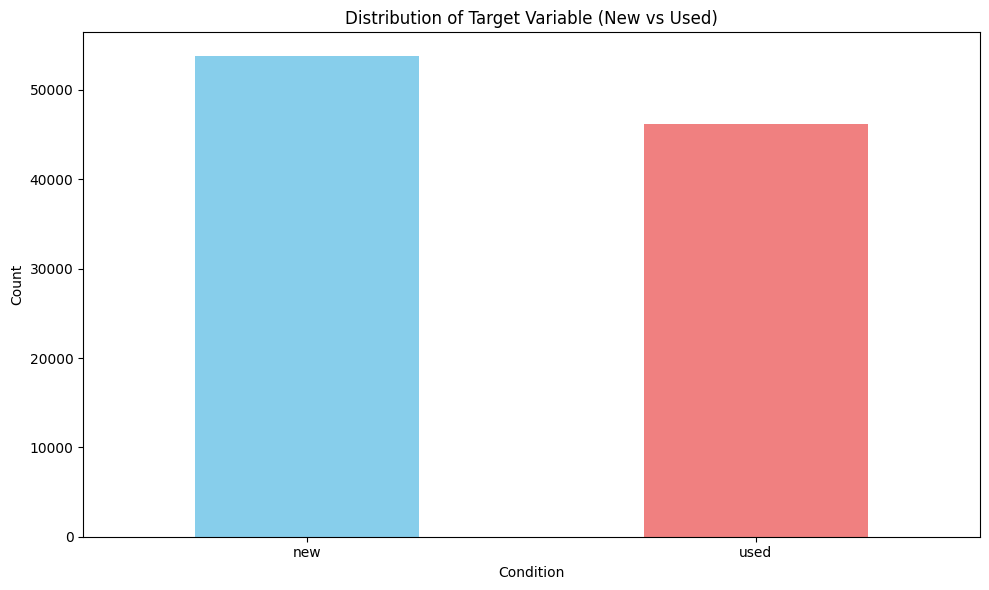

In [25]:
# Analyze the target variable
print("=== TARGET VARIABLE ANALYSIS ===")
print(f"Target column: {df['condition'].name}")
print(f"Unique values: {df['condition'].unique()}")
print(f"Value counts:\n{df['condition'].value_counts()}")
print(f"Class balance: {df['condition'].value_counts(normalize=True)}")

# Visualize target distribution
plt.figure(figsize=(10, 6))
df['condition'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Target Variable (New vs Used)')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Feature Analysis Function

In [26]:
def analyze_feature_safe(df, col):
    """
    Analyze a single feature with proper error handling for unhashable types
    """
    print(f"\n--- {col.upper()} ---")
    
    # Basic stats with error handling
    try:
        unique_count = df[col].nunique()
        print(f"Unique values: {unique_count}")
    except (TypeError, ValueError) as e:
        print(f"Unique values: Cannot calculate (unhashable type)")
        unique_count = None
        
    missing_count = df[col].isna().sum()
    missing_pct = missing_count / len(df) * 100
    print(f"Missing values: {missing_count} ({missing_pct:.2f}%)")
    
    # Data type
    print(f"Data type: {df[col].dtype}")
    
    # Sample values
    non_null_values = df[col].dropna()
    if len(non_null_values) > 0:
        sample_values = non_null_values.head(3).tolist()
        print(f"Sample values: {sample_values}")
    
    # For text features, show length statistics
    if df[col].dtype == 'object':
        try:
            text_lengths = df[col].astype(str).str.len()
            print(f"Text length - Mean: {text_lengths.mean():.1f}, Median: {text_lengths.median():.1f}, Max: {text_lengths.max()}")
        except:
            print("Text length: Cannot calculate")
    
    # For numerical features, show statistics
    if pd.api.types.is_numeric_dtype(df[col]):
        print(f"Numerical stats - Mean: {df[col].mean():.2f}, Std: {df[col].std():.2f}, Min: {df[col].min()}, Max: {df[col].max()}")
    
    # Relationship with target (if possible)
    try:
        if df[col].dtype == 'object' and unique_count and unique_count < 50:
            # For categorical with few unique values
            target_analysis = df.groupby(col)['condition'].value_counts(normalize=True).unstack(fill_value=0)
            print(f"\nTarget distribution by {col}:")
            print(target_analysis)
        elif pd.api.types.is_numeric_dtype(df[col]):
            # For numerical features
            new_condition = df[df['condition'] == 'new'][col]
            used_condition = df[df['condition'] == 'used'][col]
            print(f"\nNumerical comparison by condition:")
            print(f"New - Mean: {new_condition.mean():.2f}, Used - Mean: {used_condition.mean():.2f}")
    except Exception as e:
        print(f"Target analysis: Cannot perform ({str(e)[:50]}...)")
    
    print("-" * 50)

## 4. Text Features Analysis

In [27]:
# Identify text features
text_features = ['title', 'description', 'subtitle']
print("=== TEXT FEATURES ANALYSIS ===")

for col in text_features:
    if col in df.columns:
        analyze_feature_safe(df, col)
        
        # Word frequency analysis
        try:
            # Simple word frequency
            all_text = ' '.join(df[col].dropna().astype(str))
            words = all_text.lower().split()
            word_freq = Counter(words)
            
            print(f"\nTop 10 most common words in {col}:")
            for word, count in word_freq.most_common(10):
                print(f"  {word}: {count}")
        except Exception as e:
            print(f"Word frequency analysis failed: {str(e)[:50]}...")
    else:
        print(f"\n--- {col.upper()} ---")
        print(f"Column '{col}' not found in dataset")
        print("-" * 50)

=== TEXT FEATURES ANALYSIS ===

--- TITLE ---
Unique values: 98823
Missing values: 0 (0.00%)
Data type: object
Sample values: ['Auriculares Samsung Originales Manos Libres Cable Usb Oferta', 'Cuchillo Daga Acero Carbón Casco Yelmo Solingen Con Vaina', 'Antigua Revista Billiken, N° 1826, Año 1954']
Text length - Mean: 45.3, Median: 48.0, Max: 100
--------------------------------------------------

Top 10 most common words in title:
  de: 32662
  -: 23995
  y: 8504
  la: 7071
  para: 6028
  en: 5379
  el: 5316
  con: 5129
  del: 3224
  x: 3177

--- DESCRIPTION ---
Column 'description' not found in dataset
--------------------------------------------------

--- SUBTITLE ---
Unique values: 0
Missing values: 100000 (100.00%)
Data type: object
Text length - Mean: 4.0, Median: 4.0, Max: 4
--------------------------------------------------

Top 10 most common words in subtitle:


## 5. Numerical Features Analysis

=== NUMERICAL FEATURES ANALYSIS ===
Found 11 numerical features: ['base_price', 'seller_id', 'price', 'official_store_id', 'accepts_mercadopago', 'original_price', 'automatic_relist', 'catalog_product_id', 'initial_quantity', 'sold_quantity', 'available_quantity']

--- BASE_PRICE ---
Unique values: 10330
Missing values: 0 (0.00%)
Data type: float64
Sample values: [80.0, 2650.0, 60.0]
Numerical stats - Mean: 52524.23, Std: 8623127.16, Min: 0.84, Max: 2222222222.0

Numerical comparison by condition:
New - Mean: 44940.82, Used - Mean: 61340.22
--------------------------------------------------


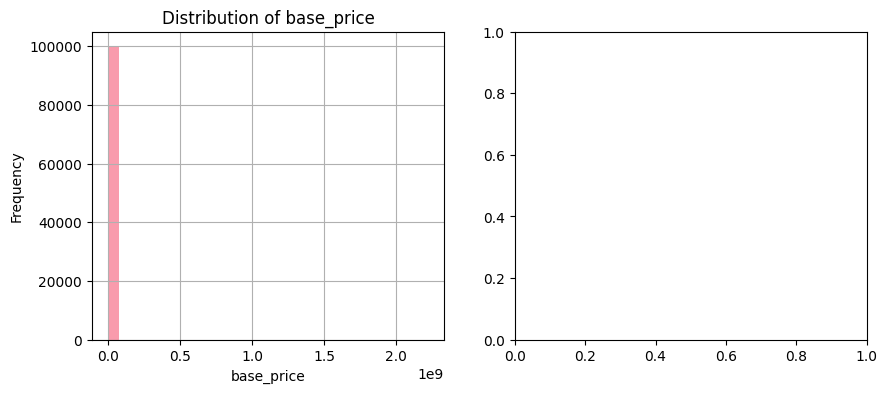

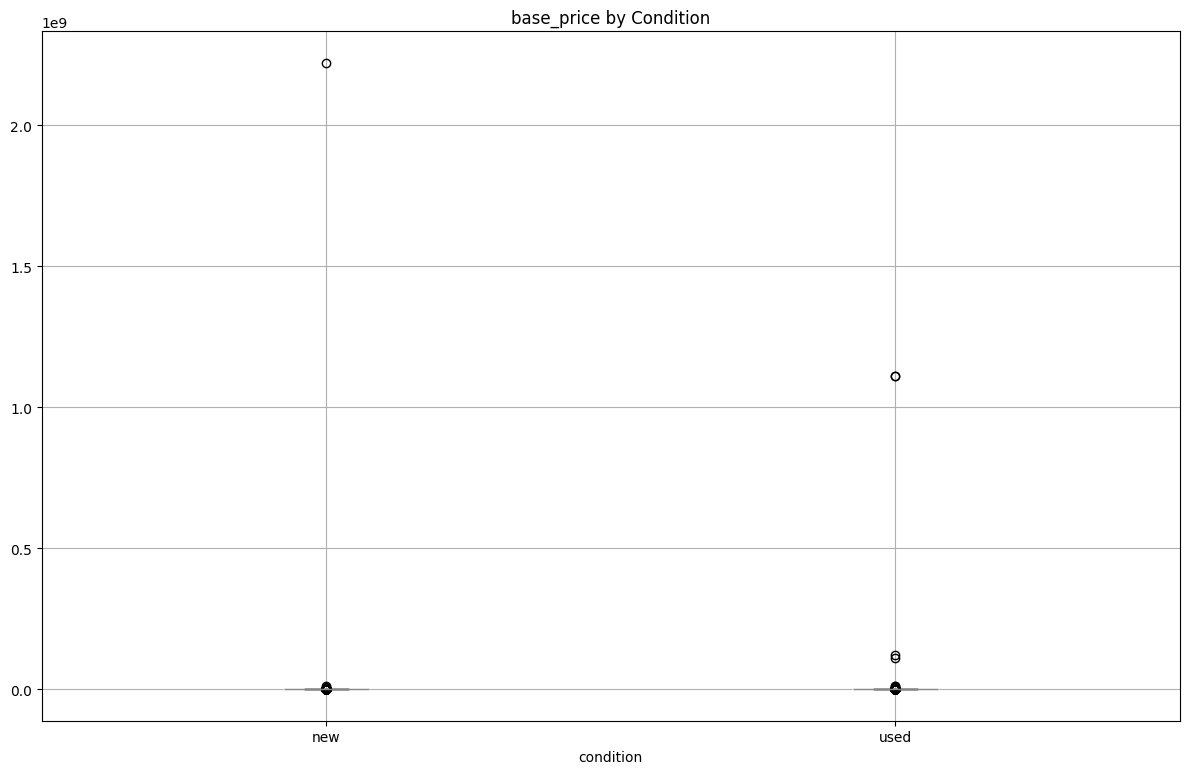


--- SELLER_ID ---
Unique values: 35916
Missing values: 0 (0.00%)
Data type: int64
Sample values: [74952096, 42093335, 133384258]
Numerical stats - Mean: 84252693.24, Std: 54972571.99, Min: 1304, Max: 194690579

Numerical comparison by condition:
New - Mean: 92348188.71, Used - Mean: 74841386.52
--------------------------------------------------


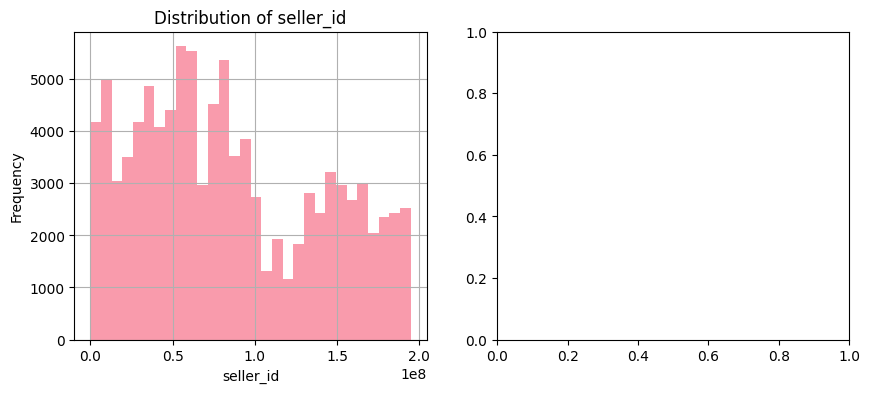

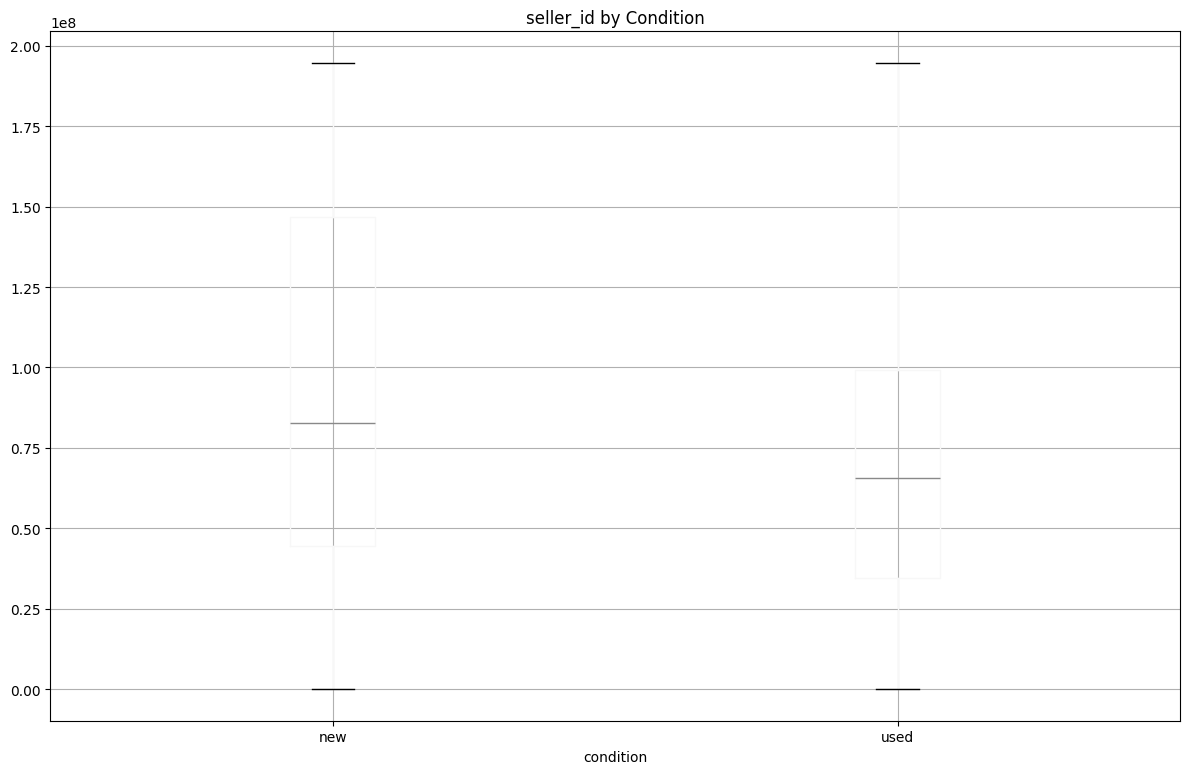


--- PRICE ---
Unique values: 10331
Missing values: 0 (0.00%)
Data type: float64
Sample values: [80.0, 2650.0, 60.0]
Numerical stats - Mean: 52524.33, Std: 8623127.16, Min: 0.84, Max: 2222222222.0

Numerical comparison by condition:
New - Mean: 44940.95, Used - Mean: 61340.27
--------------------------------------------------


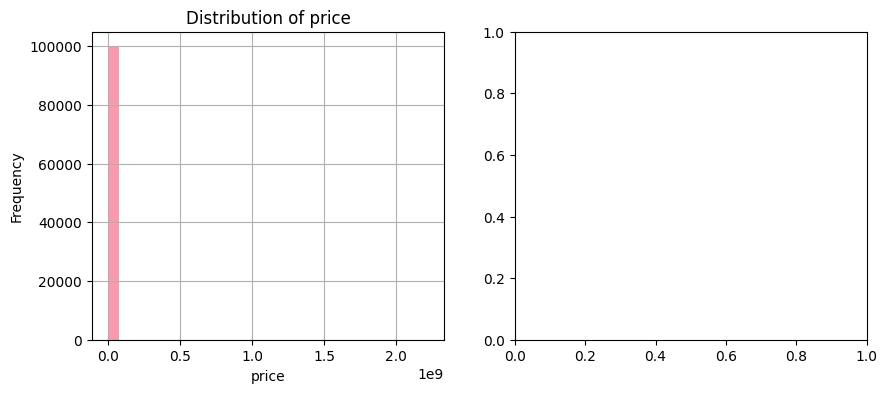

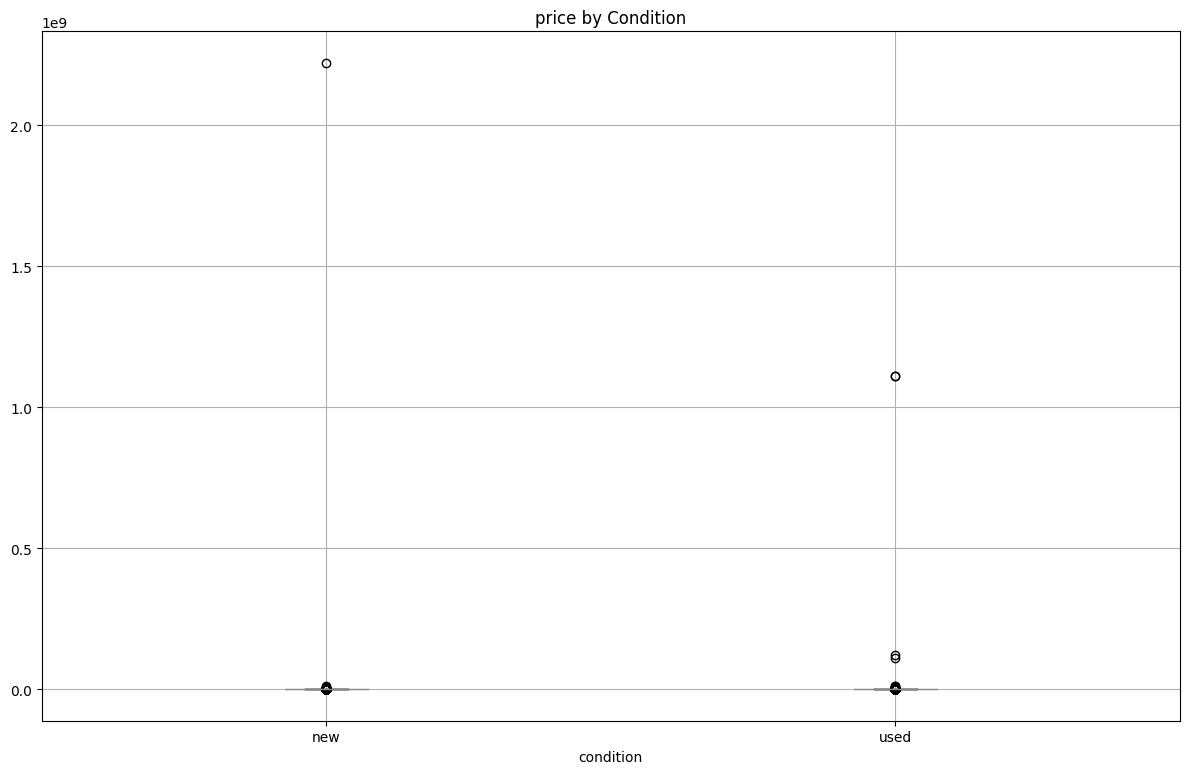


--- OFFICIAL_STORE_ID ---
Unique values: 202
Missing values: 99182 (99.18%)
Data type: float64
Sample values: [322.0, 308.0, 216.0]
Numerical stats - Mean: 206.44, Std: 128.25, Min: 1.0, Max: 446.0

Numerical comparison by condition:
New - Mean: 206.19, Used - Mean: 215.55
--------------------------------------------------


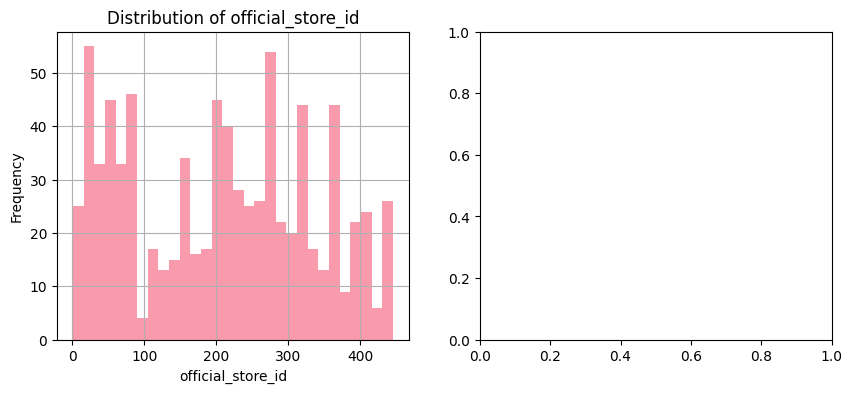

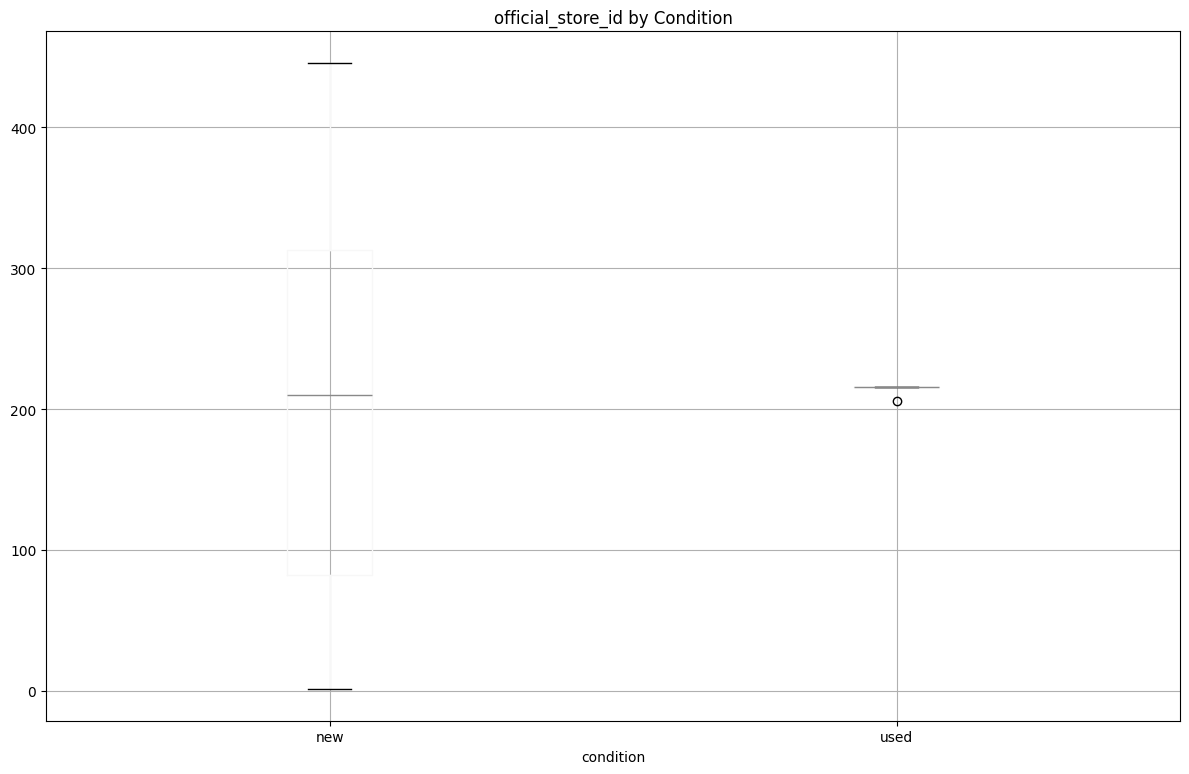


--- ACCEPTS_MERCADOPAGO ---
Unique values: 2
Missing values: 0 (0.00%)
Data type: bool
Sample values: [True, True, True]
Numerical stats - Mean: 0.98, Std: 0.15, Min: False, Max: True

Numerical comparison by condition:
New - Mean: 0.99, Used - Mean: 0.96
--------------------------------------------------
Plotting failed for accepts_mercadopago: numpy boolean subtract, the `-` operator, is not s...

--- ORIGINAL_PRICE ---
Unique values: 114
Missing values: 99857 (99.86%)
Data type: float64
Sample values: [750.0, 10610.0, 1099.0]
Numerical stats - Mean: 1593.34, Std: 2245.80, Min: 120.0, Max: 13999.0

Numerical comparison by condition:
New - Mean: 1593.34, Used - Mean: nan
--------------------------------------------------


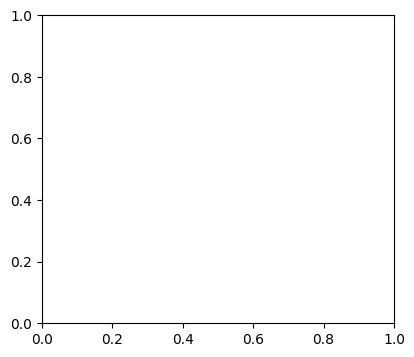

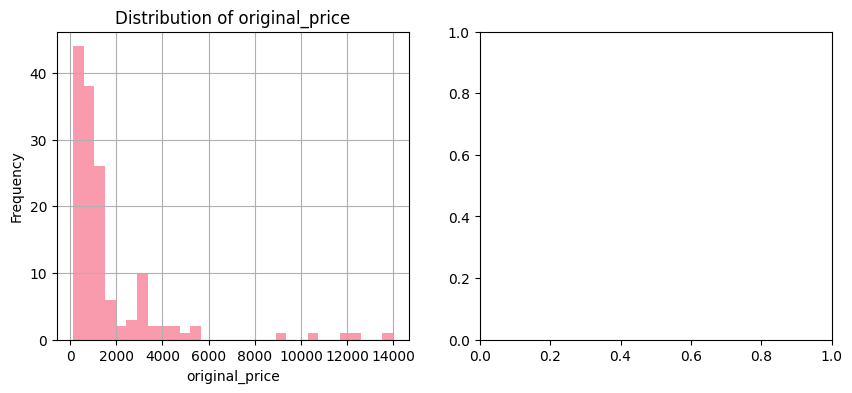

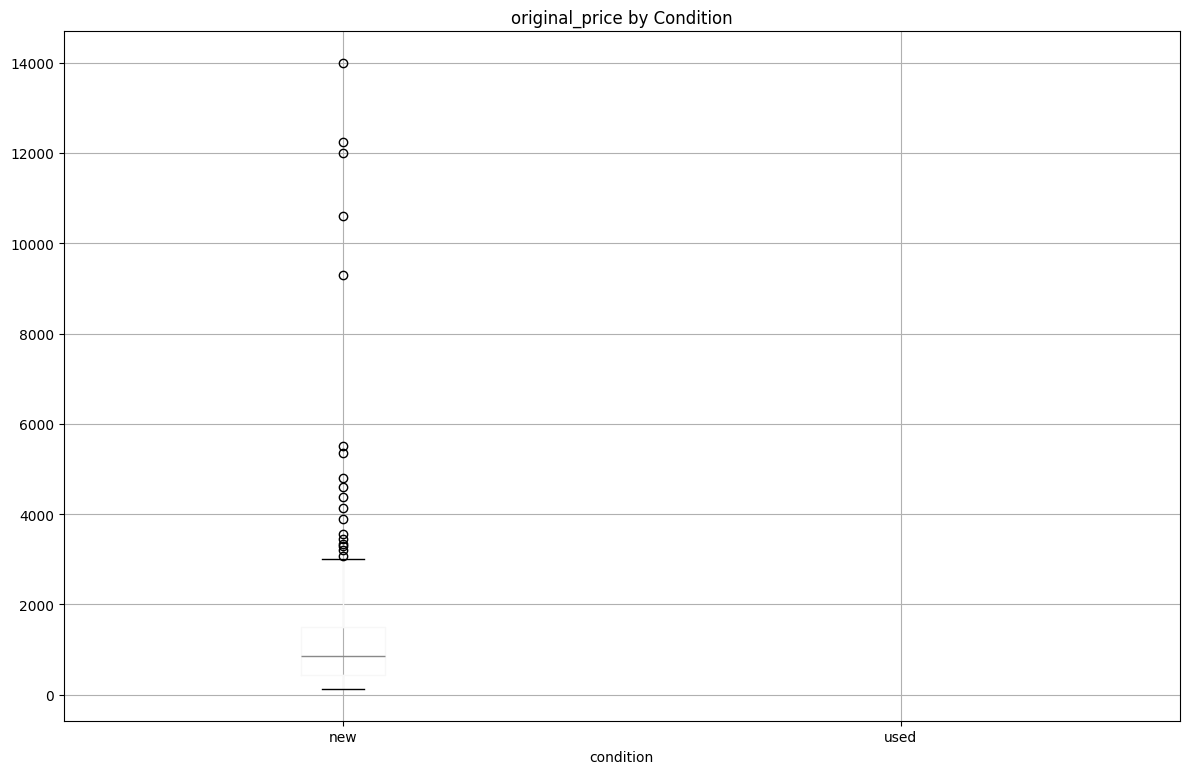


--- AUTOMATIC_RELIST ---
Unique values: 2
Missing values: 0 (0.00%)
Data type: bool
Sample values: [False, False, False]
Numerical stats - Mean: 0.05, Std: 0.21, Min: False, Max: True

Numerical comparison by condition:
New - Mean: 0.08, Used - Mean: 0.00
--------------------------------------------------
Plotting failed for automatic_relist: numpy boolean subtract, the `-` operator, is not s...

--- CATALOG_PRODUCT_ID ---
Unique values: 9
Missing values: 99989 (99.99%)
Data type: float64
Sample values: [800744.0, 5093232.0, 3050291.0]
Numerical stats - Mean: 3727643.18, Std: 1884697.95, Min: 94404.0, Max: 5434513.0

Numerical comparison by condition:
New - Mean: 3942058.50, Used - Mean: 3605120.14
--------------------------------------------------


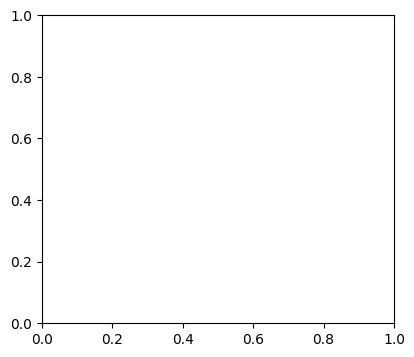

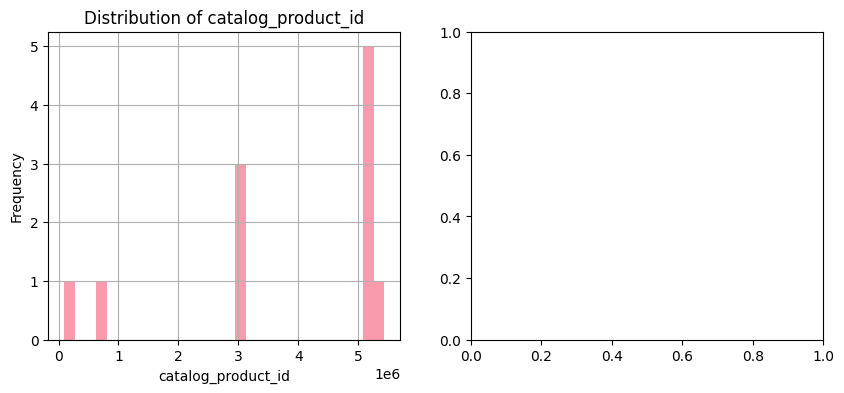

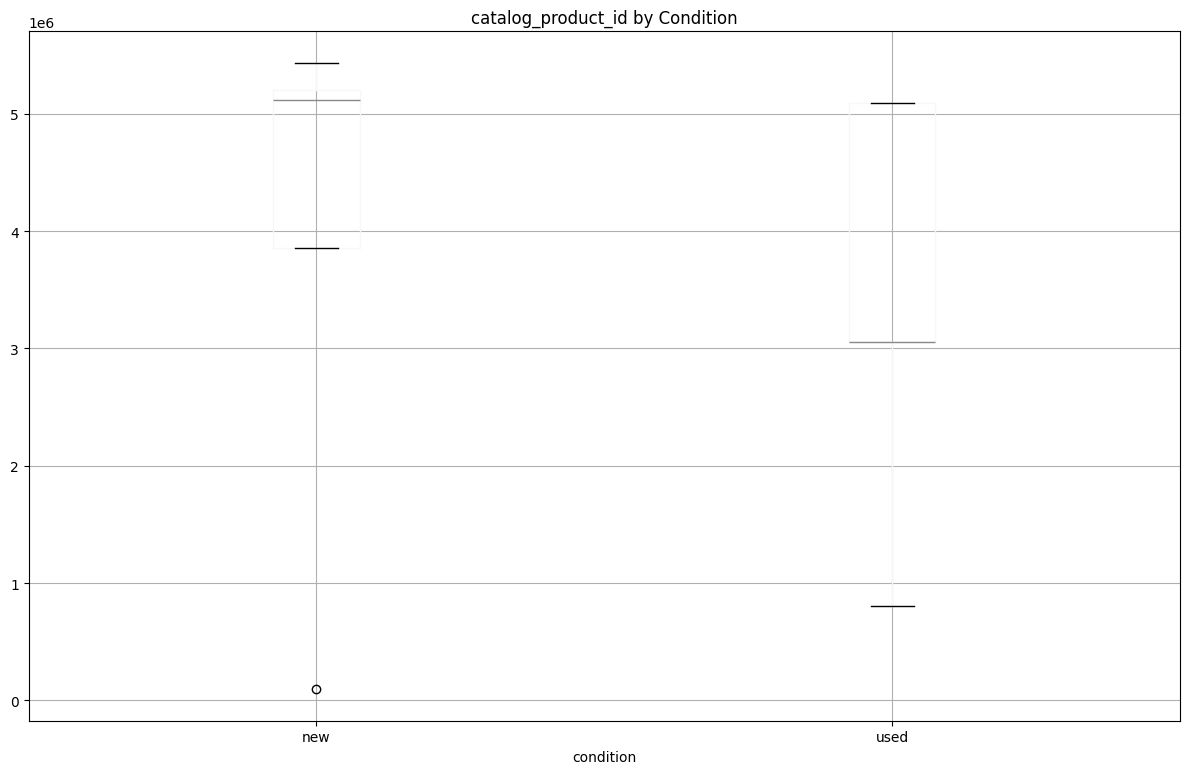


--- INITIAL_QUANTITY ---
Unique values: 450
Missing values: 0 (0.00%)
Data type: int64
Sample values: [1, 1, 1]
Numerical stats - Mean: 35.09, Std: 421.08, Min: 1, Max: 9999

Numerical comparison by condition:
New - Mean: 63.55, Used - Mean: 2.01
--------------------------------------------------


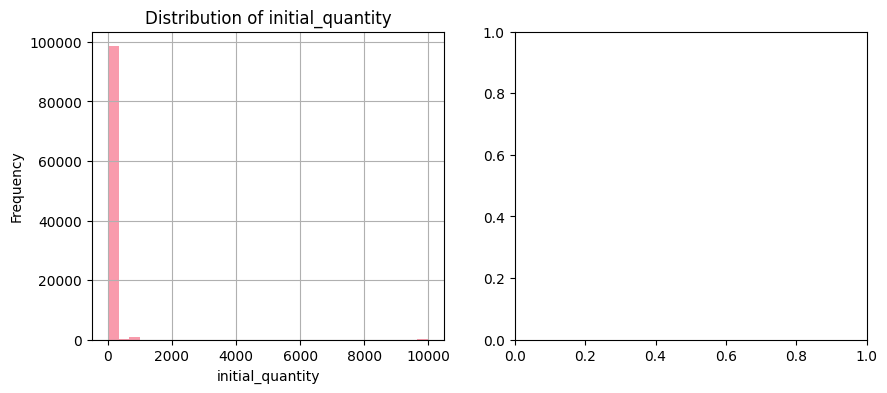

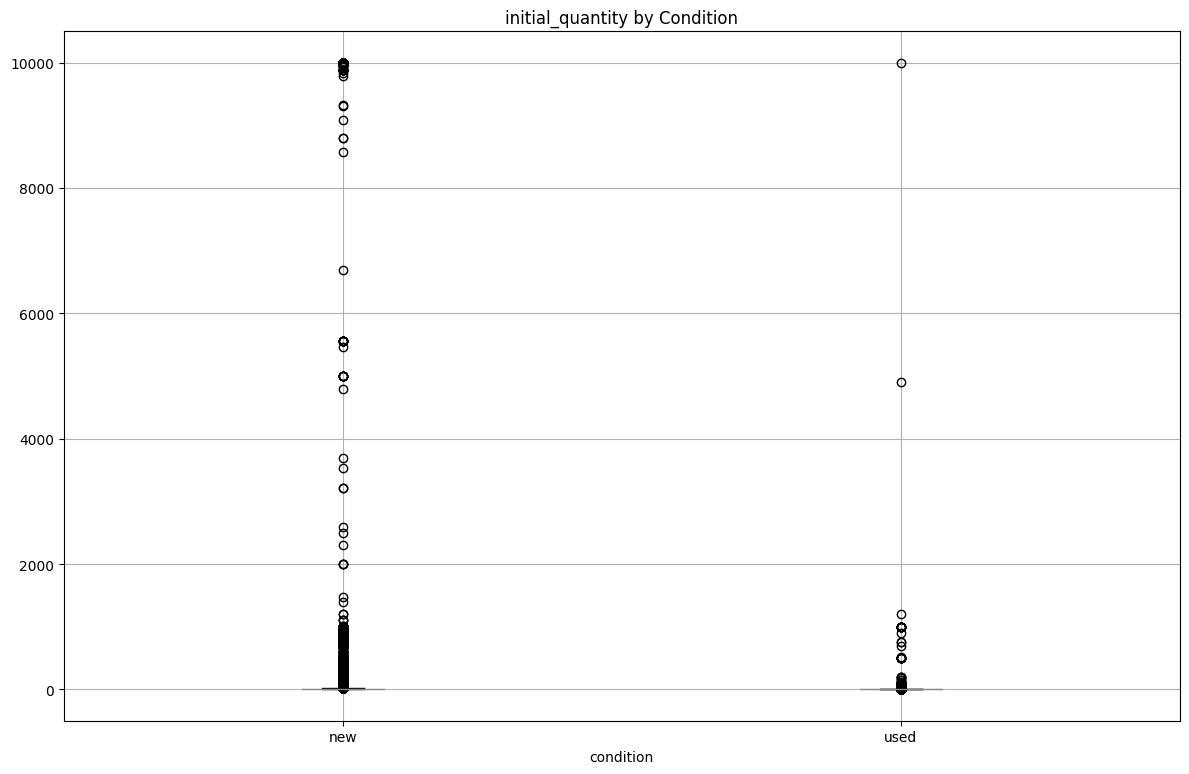


--- SOLD_QUANTITY ---
Unique values: 317
Missing values: 0 (0.00%)
Data type: int64
Sample values: [0, 0, 0]
Numerical stats - Mean: 2.40, Std: 42.69, Min: 0, Max: 8676

Numerical comparison by condition:
New - Mean: 4.38, Used - Mean: 0.09
--------------------------------------------------


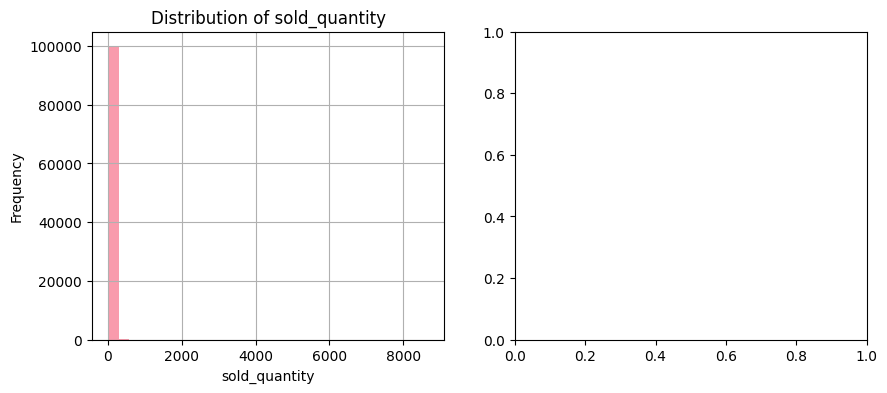

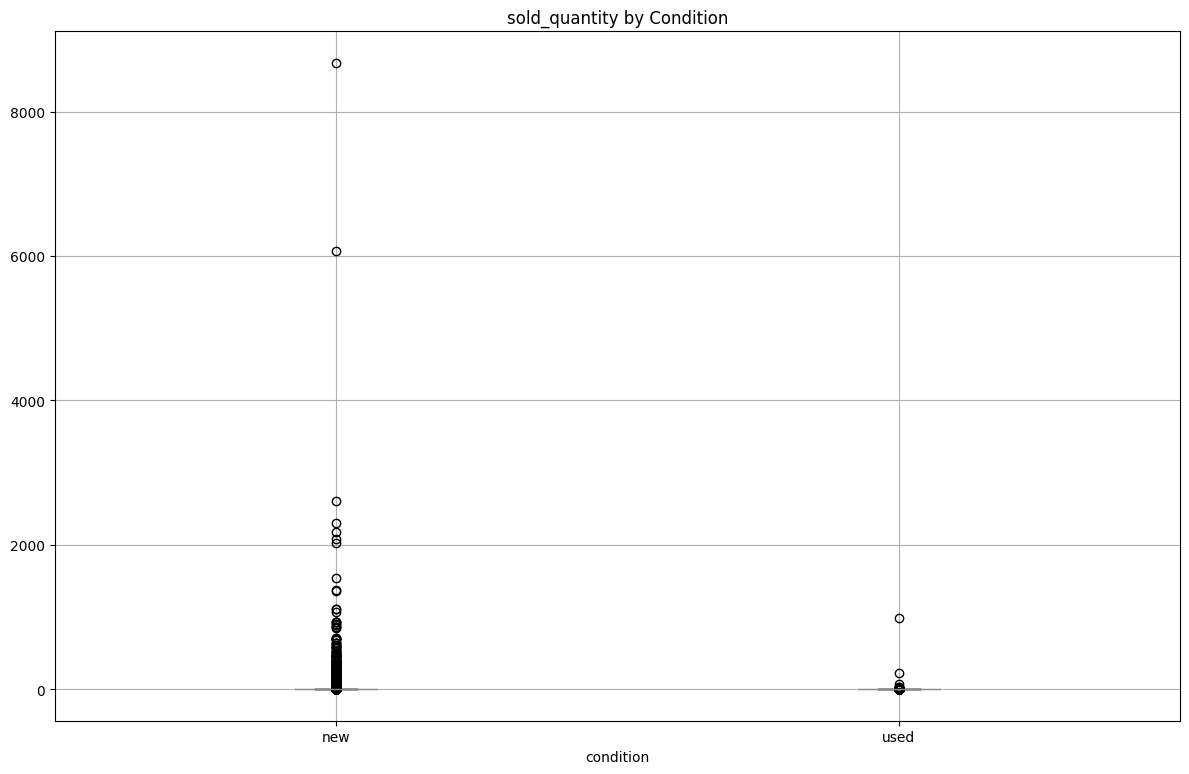


--- AVAILABLE_QUANTITY ---
Unique values: 468
Missing values: 0 (0.00%)
Data type: int64
Sample values: [1, 1, 1]
Numerical stats - Mean: 34.84, Std: 420.81, Min: 1, Max: 9999

Numerical comparison by condition:
New - Mean: 63.10, Used - Mean: 1.99
--------------------------------------------------


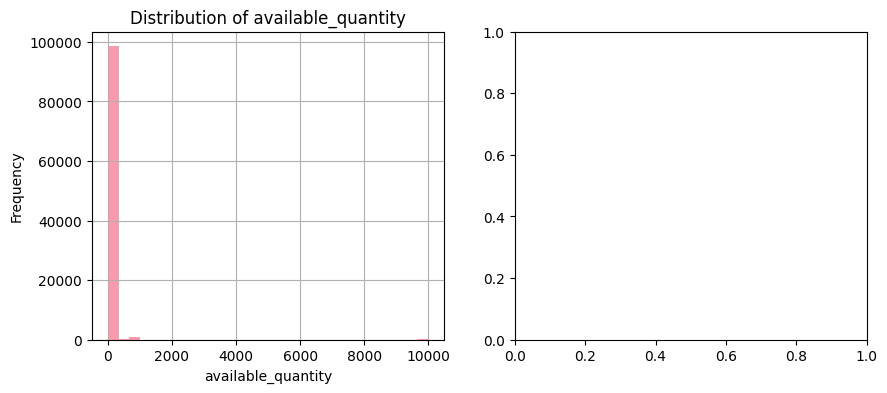

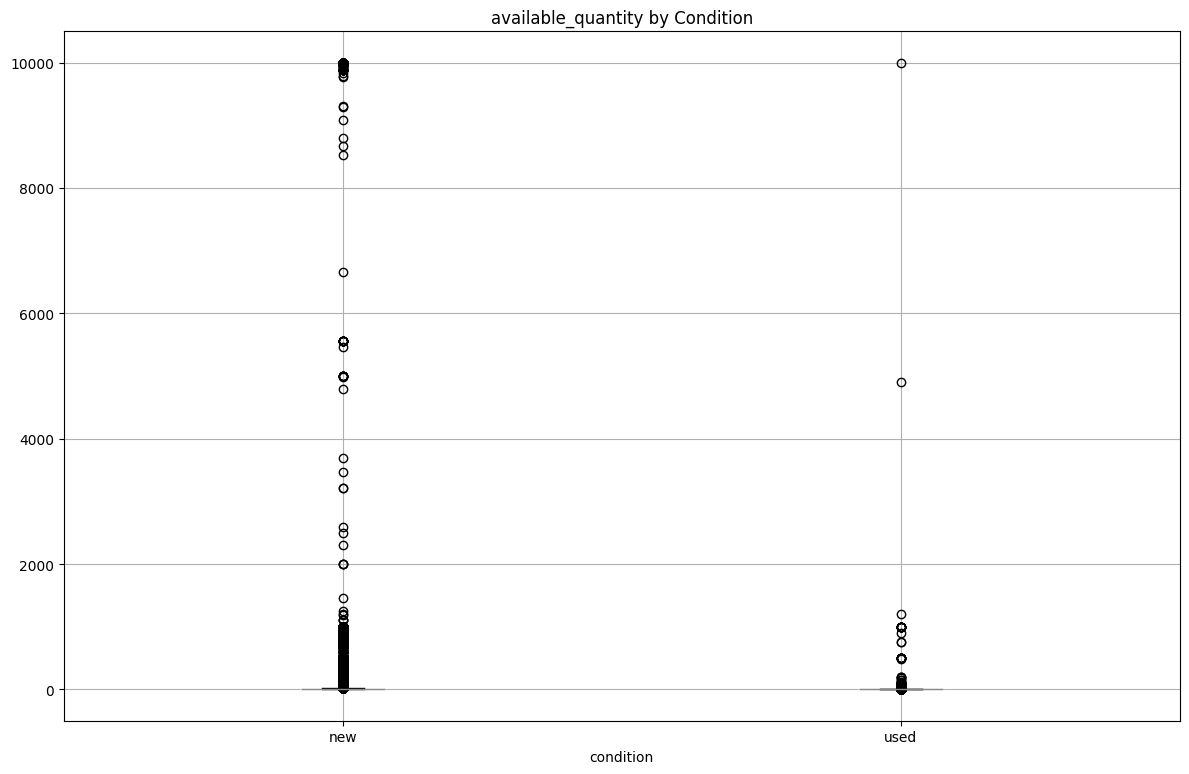

In [28]:
# Identify numerical features
numerical_features = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
print(f"=== NUMERICAL FEATURES ANALYSIS ===")
print(f"Found {len(numerical_features)} numerical features: {numerical_features}")

for col in numerical_features:
    analyze_feature_safe(df, col)
    
    # Distribution plot (only if we have numeric data)
    try:
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        df[col].hist(bins=30, alpha=0.7)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        df.boxplot(column=col, by='condition')
        plt.title(f'{col} by Condition')
        plt.suptitle('')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Plotting failed for {col}: {str(e)[:50]}...")

## 6. Categorical Features Analysis (SAFE)

=== CATEGORICAL FEATURES ANALYSIS ===
Found 9 categorical features: ['condition', 'site_id', 'listing_type_id', 'buying_mode', 'listing_source', 'international_delivery_mode', 'differential_pricing', 'currency_id', 'status']

--- CONDITION ---
Unique values: 2
Missing values: 0 (0.00%)
Data type: object
Sample values: ['new', 'used', 'used']
Text length - Mean: 3.5, Median: 3.0, Max: 4
Target analysis: Cannot perform (index must be a MultiIndex to unstack, <class 'pan...)
--------------------------------------------------


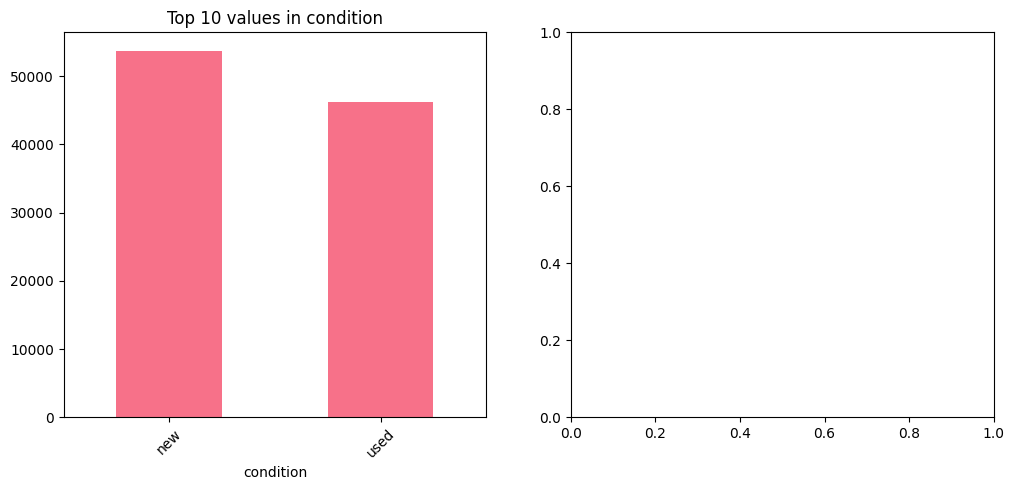

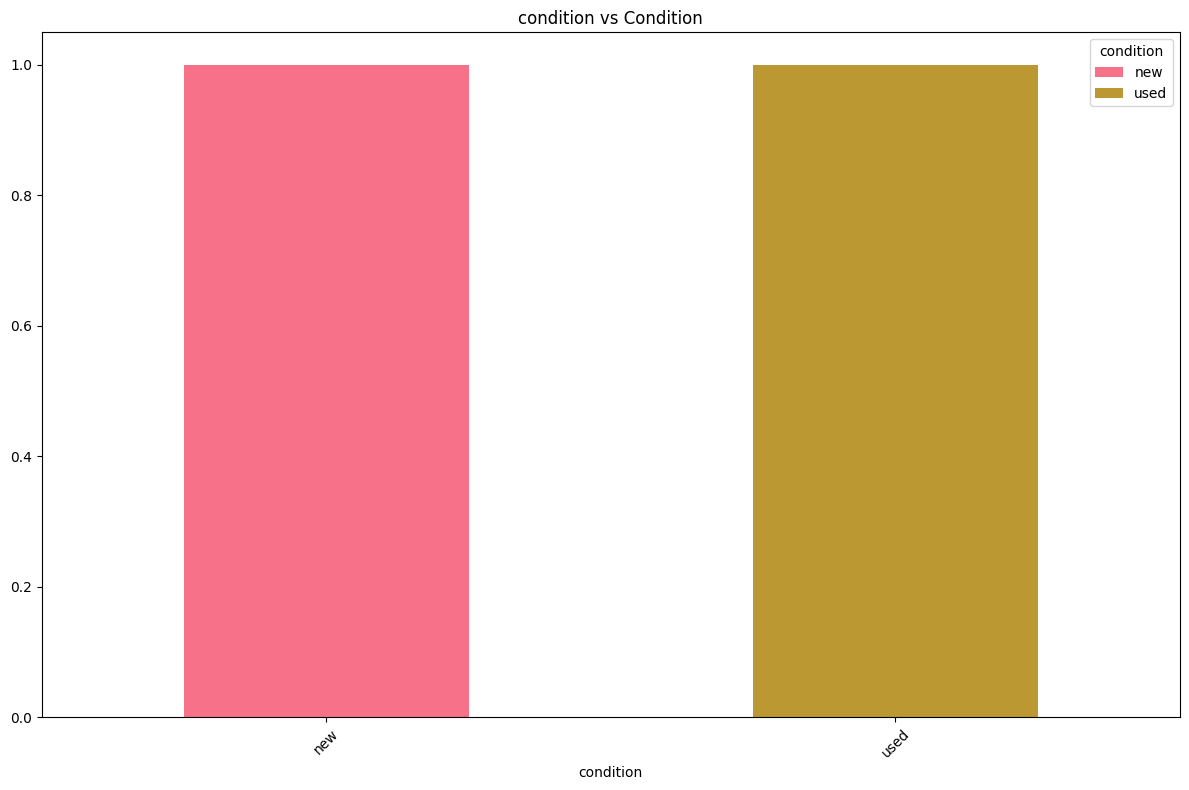


--- SITE_ID ---
Unique values: 1
Missing values: 0 (0.00%)
Data type: object
Sample values: ['MLA', 'MLA', 'MLA']
Text length - Mean: 3.0, Median: 3.0, Max: 3

Target distribution by site_id:
condition      new     used
site_id                    
MLA        0.53758  0.46242
--------------------------------------------------


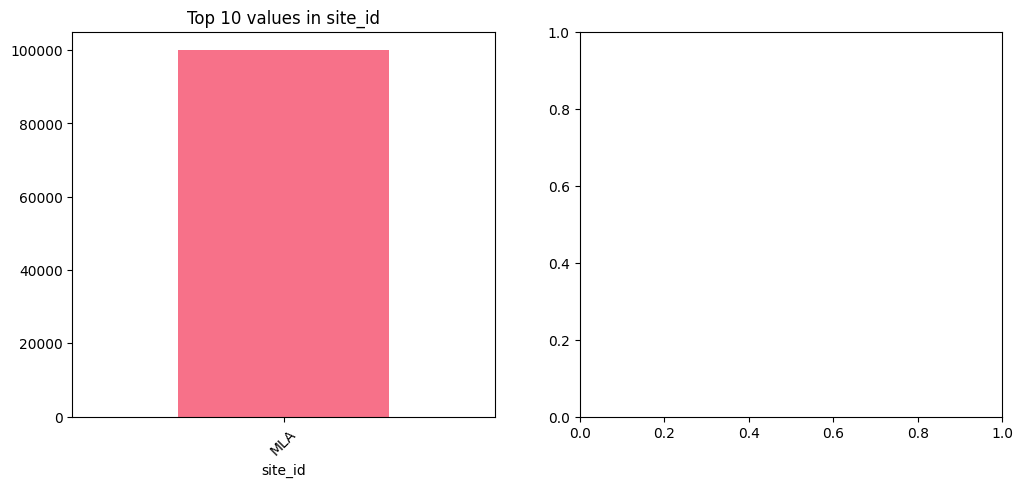

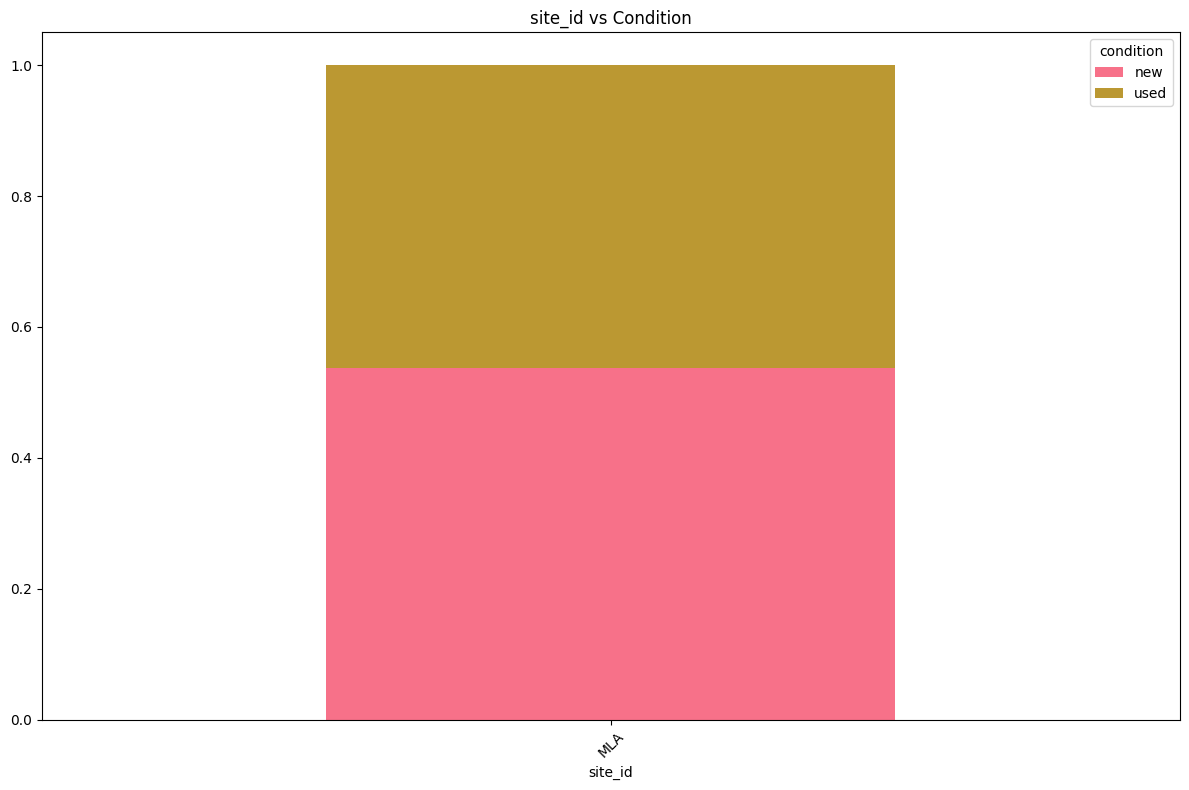


--- LISTING_TYPE_ID ---
Unique values: 7
Missing values: 0 (0.00%)
Data type: object
Sample values: ['bronze', 'silver', 'bronze']
Text length - Mean: 5.8, Median: 6.0, Max: 12

Target distribution by listing_type_id:
condition             new      used
listing_type_id                    
bronze           0.622621  0.377379
free             0.074013  0.925987
gold             0.864213  0.135787
gold_premium     0.534442  0.465558
gold_pro         1.000000  0.000000
gold_special     0.981475  0.018525
silver           0.800527  0.199473
--------------------------------------------------


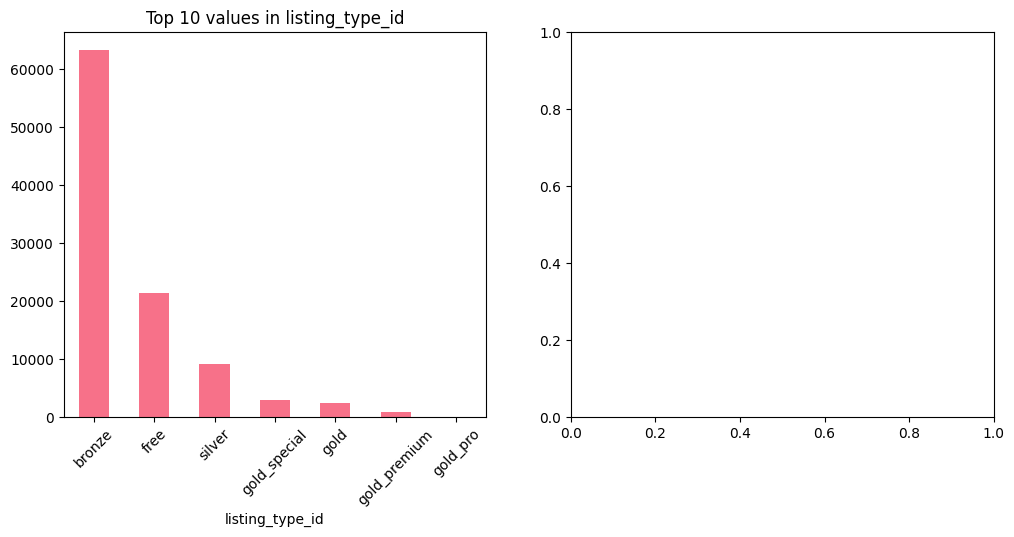

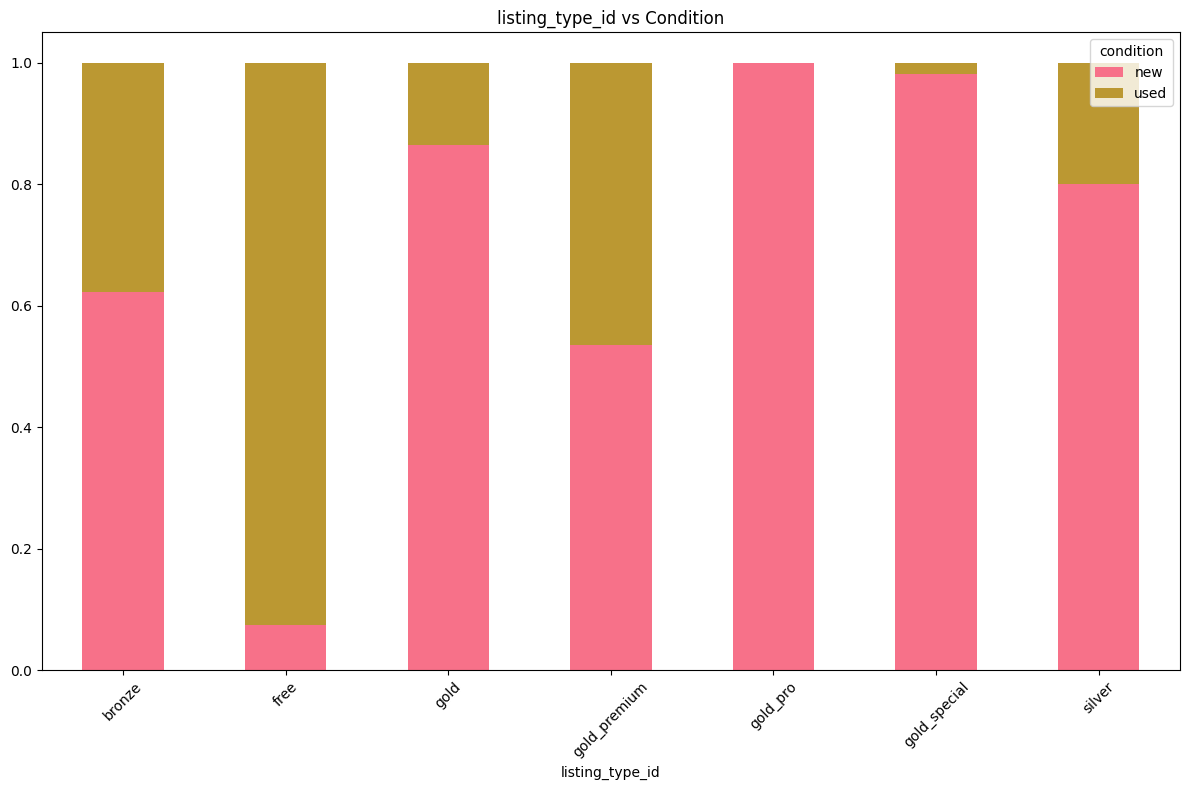


--- BUYING_MODE ---
Unique values: 3
Missing values: 0 (0.00%)
Data type: object
Sample values: ['buy_it_now', 'buy_it_now', 'buy_it_now']
Text length - Mean: 10.0, Median: 10.0, Max: 10

Target distribution by buying_mode:
condition         new      used
buying_mode                    
auction      0.320513  0.679487
buy_it_now   0.546448  0.453552
classified   0.226228  0.773772
--------------------------------------------------


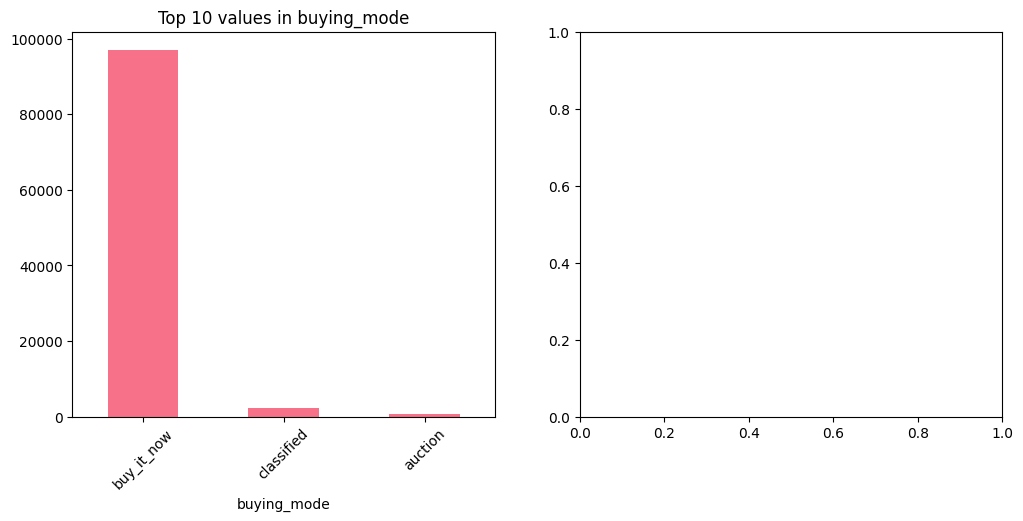

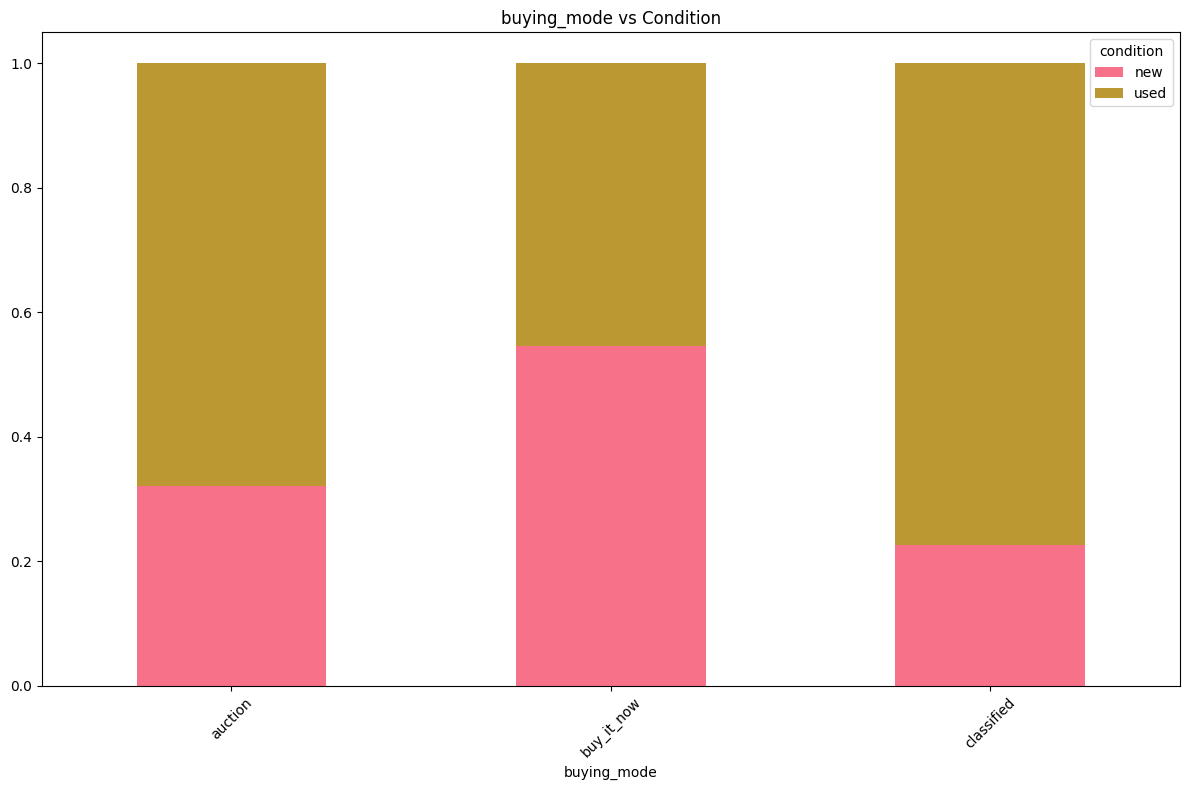


--- LISTING_SOURCE ---
Unique values: 1
Missing values: 0 (0.00%)
Data type: object
Sample values: ['', '', '']
Text length - Mean: 0.0, Median: 0.0, Max: 0

Target distribution by listing_source:
condition           new     used
listing_source                  
                0.53758  0.46242
--------------------------------------------------


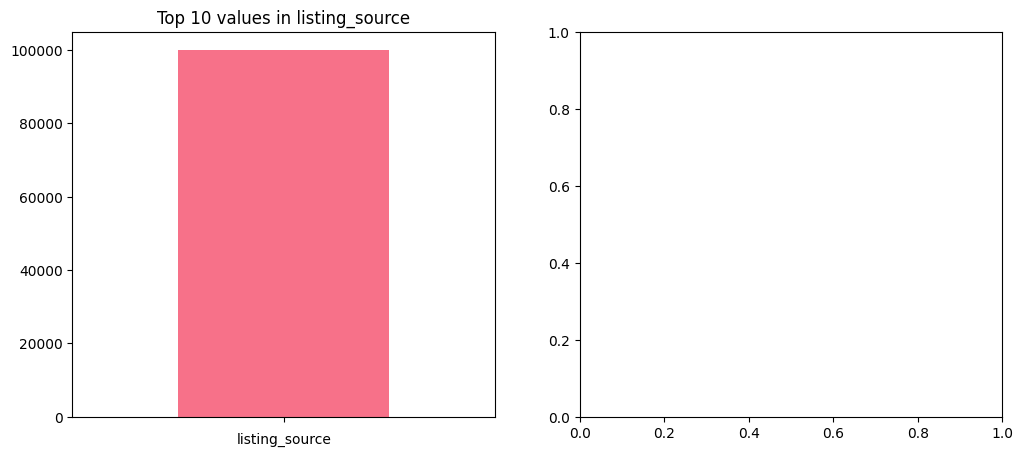

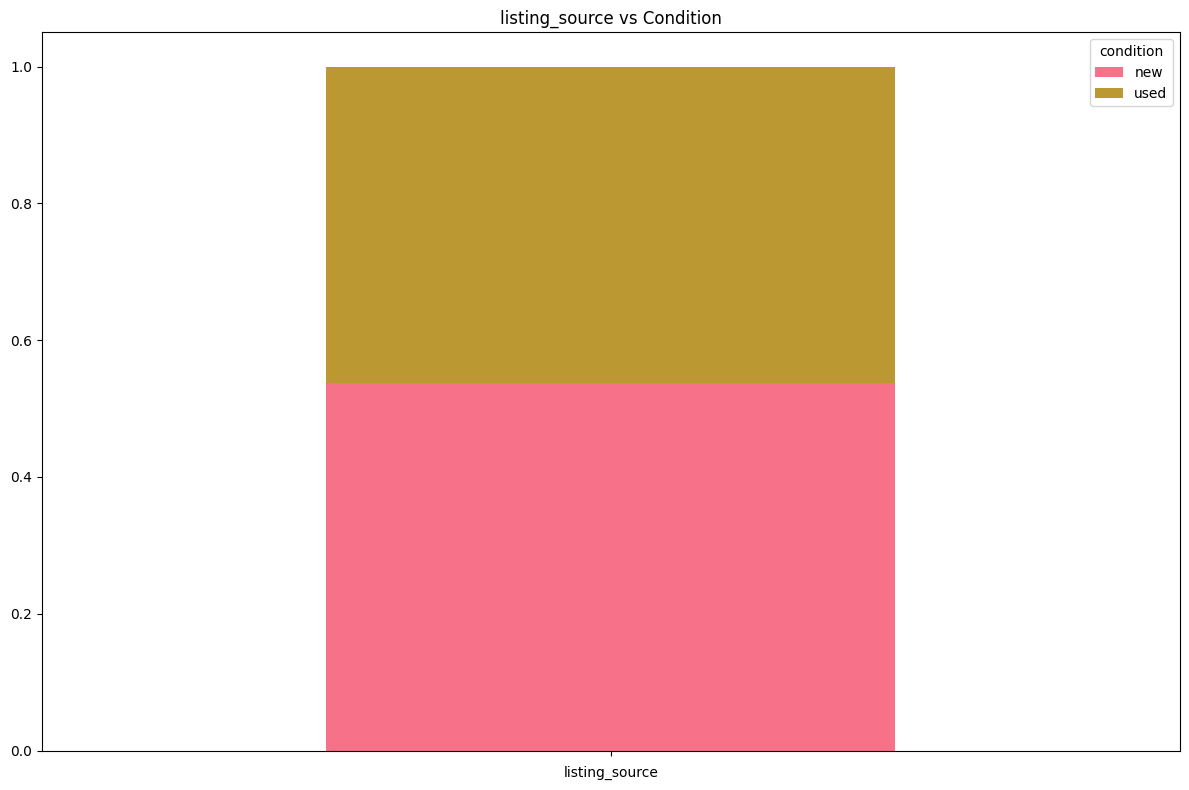


--- INTERNATIONAL_DELIVERY_MODE ---
Unique values: 1
Missing values: 0 (0.00%)
Data type: object
Sample values: ['none', 'none', 'none']
Text length - Mean: 4.0, Median: 4.0, Max: 4

Target distribution by international_delivery_mode:
condition                        new     used
international_delivery_mode                  
none                         0.53758  0.46242
--------------------------------------------------


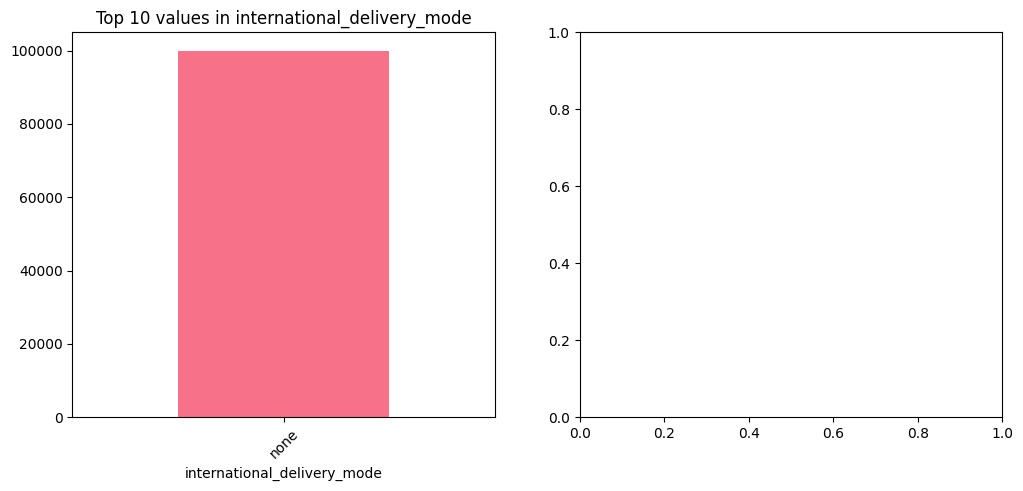

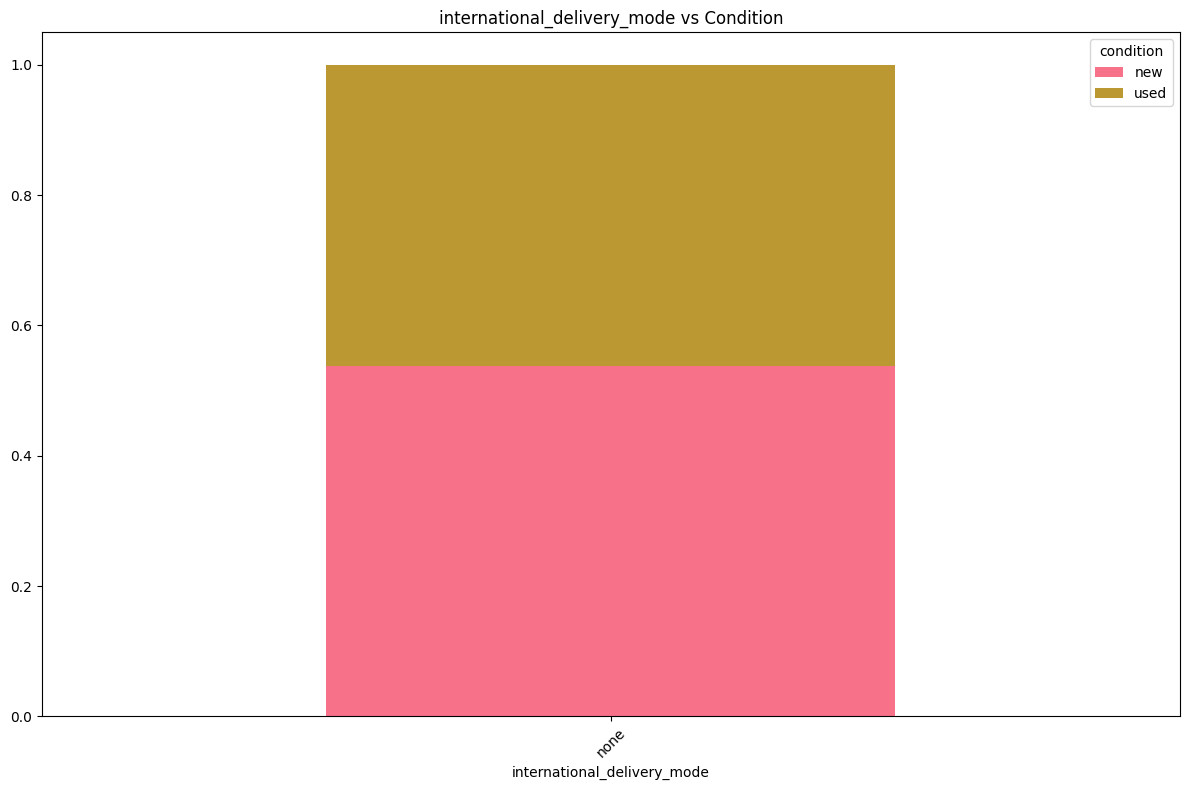


--- DIFFERENTIAL_PRICING ---
Unique values: 0
Missing values: 100000 (100.00%)
Data type: object
Text length - Mean: 4.0, Median: 4.0, Max: 4
--------------------------------------------------
Plotting failed for differential_pricing: index 0 is out of bounds for axis 0 with size 0...

--- CURRENCY_ID ---
Unique values: 2
Missing values: 0 (0.00%)
Data type: object
Sample values: ['ARS', 'ARS', 'ARS']
Text length - Mean: 3.0, Median: 3.0, Max: 3

Target distribution by currency_id:
condition         new      used
currency_id                    
ARS          0.538533  0.461467
USD          0.370370  0.629630
--------------------------------------------------


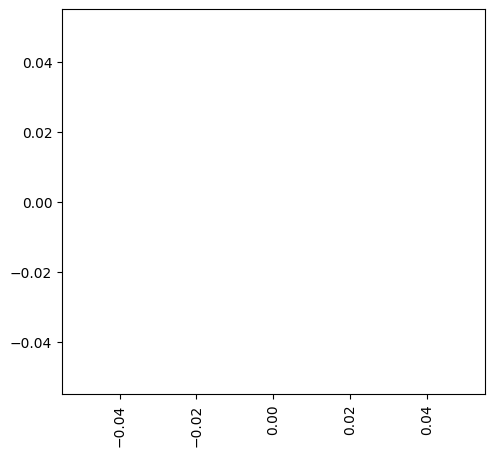

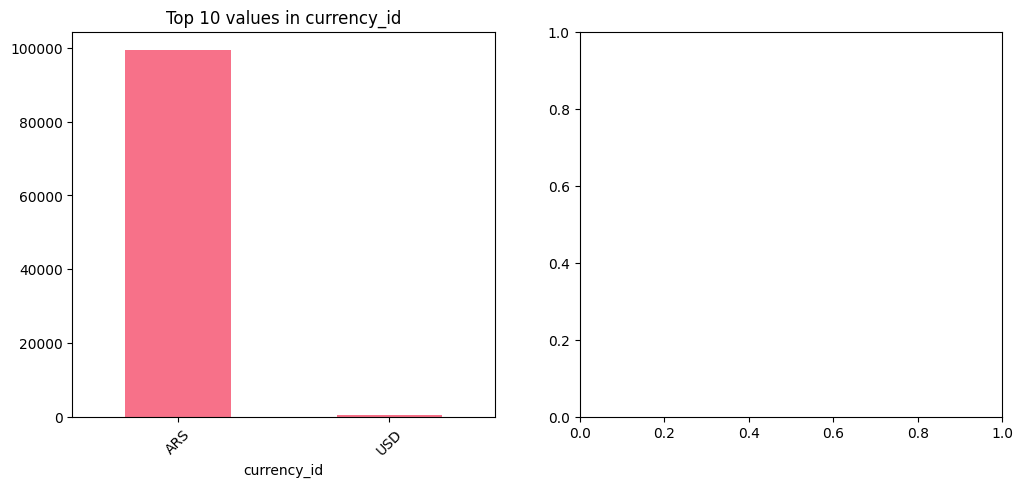

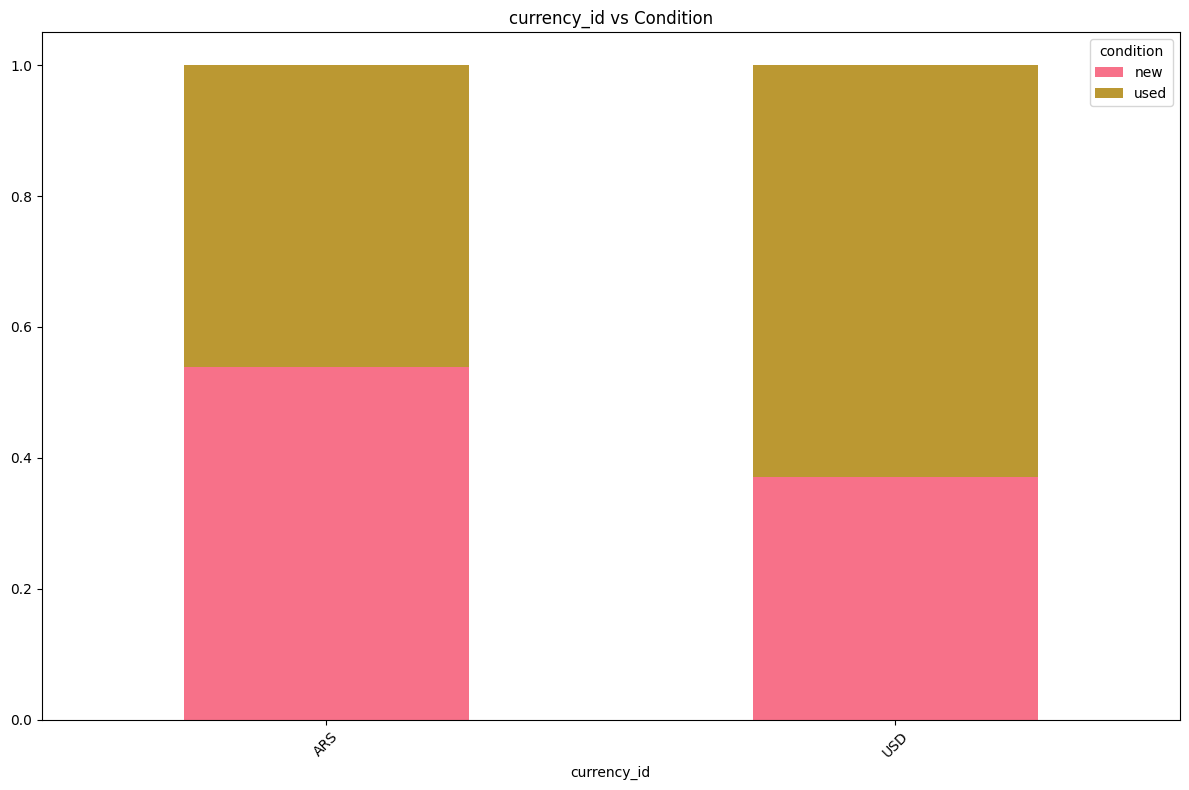


--- STATUS ---
Unique values: 4
Missing values: 0 (0.00%)
Data type: object
Sample values: ['active', 'active', 'active']
Text length - Mean: 6.0, Median: 6.0, Max: 14

Target distribution by status:
condition            new      used
status                            
active          0.531058  0.468942
closed          0.450000  0.550000
not_yet_active  1.000000  0.000000
paused          0.682853  0.317147
--------------------------------------------------


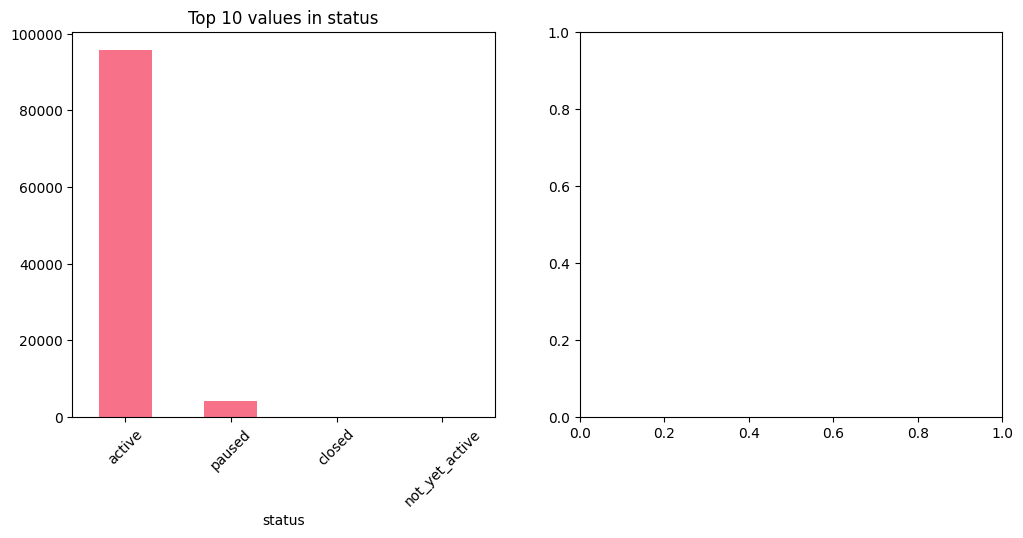

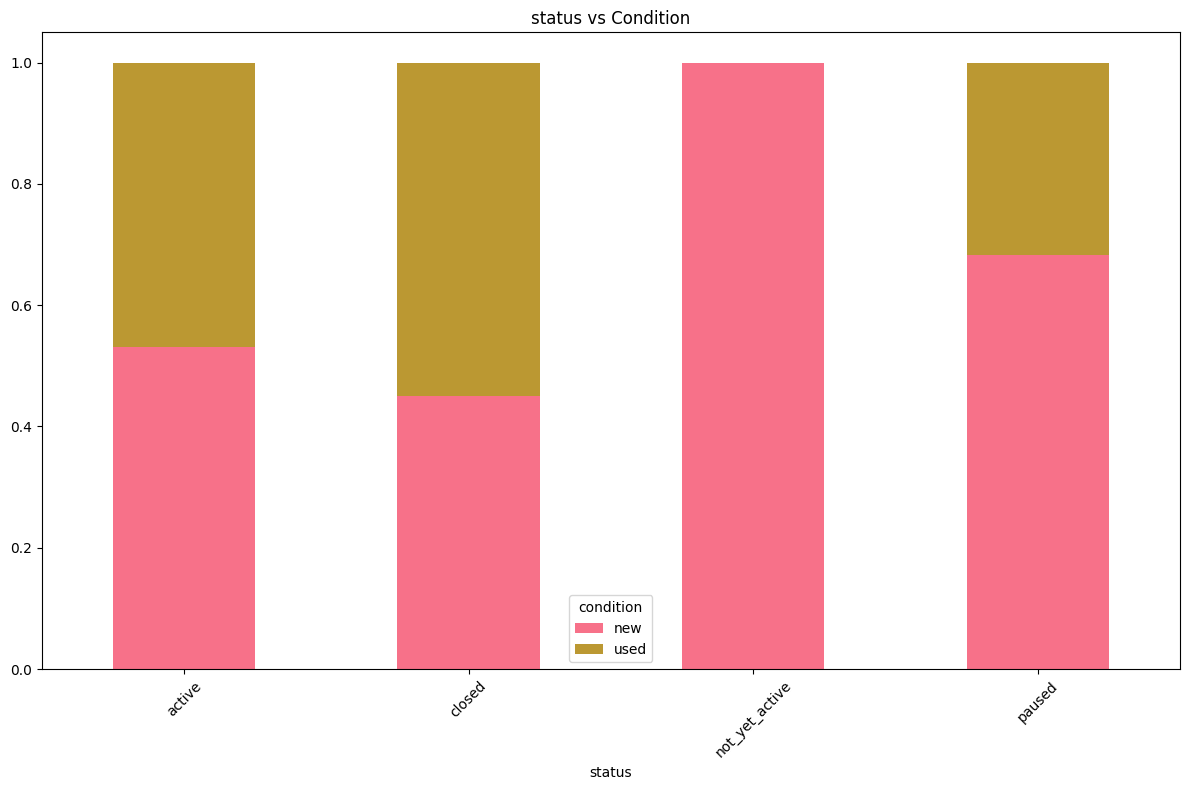

In [29]:
# Identify categorical features (object type with reasonable number of unique values)
categorical_features = []
for col in df.columns:
    if df[col].dtype == 'object' and col not in text_features:
        try:
            unique_count = df[col].nunique()
            if unique_count < 100:  # Reasonable number for categorical
                categorical_features.append(col)
        except (TypeError, ValueError):
            # Skip columns that can't be analyzed
            continue

print(f"=== CATEGORICAL FEATURES ANALYSIS ===")
print(f"Found {len(categorical_features)} categorical features: {categorical_features}")

for col in categorical_features:
    analyze_feature_safe(df, col)
    
    # Distribution plot (only for safe categorical features)
    try:
        # Check if we can safely plot this column
        sample_values = df[col].dropna().head(10)
        can_plot = True
        for val in sample_values:
            if isinstance(val, (dict, list)):
                can_plot = False
                break
        
        if can_plot:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            df[col].value_counts().head(10).plot(kind='bar')
            plt.title(f'Top 10 values in {col}')
            plt.xticks(rotation=45)
            
            plt.subplot(1, 2, 2)
            # Safe cross-tabulation
            try:
                cross_tab = pd.crosstab(df[col], df['condition'], normalize='index')
                cross_tab.plot(kind='bar', stacked=True)
                plt.title(f'{col} vs Condition')
                plt.xticks(rotation=45)
            except:
                plt.text(0.5, 0.5, 'Cannot plot due to data complexity', 
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title(f'{col} vs Condition (Complex Data)')
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping plots for {col} - contains complex data types")
    except Exception as e:
        print(f"Plotting failed for {col}: {str(e)[:50]}...")

## 7. Complex Features Analysis (Dictionaries, Lists, etc.)

In [30]:
# Identify complex features (dictionaries, lists, etc.)
complex_features = []
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            # Check if it contains dictionaries or lists
            sample_values = df[col].dropna().head(5)
            for val in sample_values:
                if isinstance(val, (dict, list)):
                    complex_features.append(col)
                    break
        except:
            continue

print(f"=== COMPLEX FEATURES ANALYSIS ===")
print(f"Found {len(complex_features)} complex features: {complex_features}")

for col in complex_features:
    print(f"\n--- {col.upper()} ---")
    
    # Sample the complex data
    non_null_values = df[col].dropna()
    print(f"Non-null count: {len(non_null_values)}")
    
    # Show sample structure
    sample_values = non_null_values.head(3)
    print(f"Sample values:")
    for i, val in enumerate(sample_values):
        print(f"  {i+1}. Type: {type(val)}, Value: {str(val)[:100]}...")
    
    # Try to extract useful information
    if len(non_null_values) > 0:
        first_val = non_null_values.iloc[0]
        if isinstance(first_val, dict):
            print(f"\nDictionary keys: {list(first_val.keys())}")
        elif isinstance(first_val, list):
            print(f"\nList length: {len(first_val)}")
    
    print("-" * 50)

=== COMPLEX FEATURES ANALYSIS ===
Found 14 complex features: ['seller_address', 'sub_status', 'seller_contact', 'deal_ids', 'shipping', 'non_mercado_pago_payment_methods', 'variations', 'location', 'attributes', 'tags', 'coverage_areas', 'descriptions', 'pictures', 'geolocation']

--- SELLER_ADDRESS ---
Non-null count: 100000
Sample values:
  1. Type: <class 'dict'>, Value: {'comment': '', 'longitude': -58.3986709, 'id': 78162842, 'country': {'name': 'Argentina', 'id': 'AR...
  2. Type: <class 'dict'>, Value: {'comment': '', 'longitude': -58.5059173, 'id': 105272448, 'country': {'name': 'Argentina', 'id': 'A...
  3. Type: <class 'dict'>, Value: {'comment': '', 'longitude': -58.4143948, 'id': 103489016, 'country': {'name': 'Argentina', 'id': 'A...

Dictionary keys: ['comment', 'longitude', 'id', 'country', 'address_line', 'latitude', 'search_location', 'zip_code', 'city', 'state']
--------------------------------------------------

--- SUB_STATUS ---
Non-null count: 100000
Sample values

## 8. Feature Correlation Analysis (SAFE)

=== FEATURE CORRELATION ANALYSIS ===


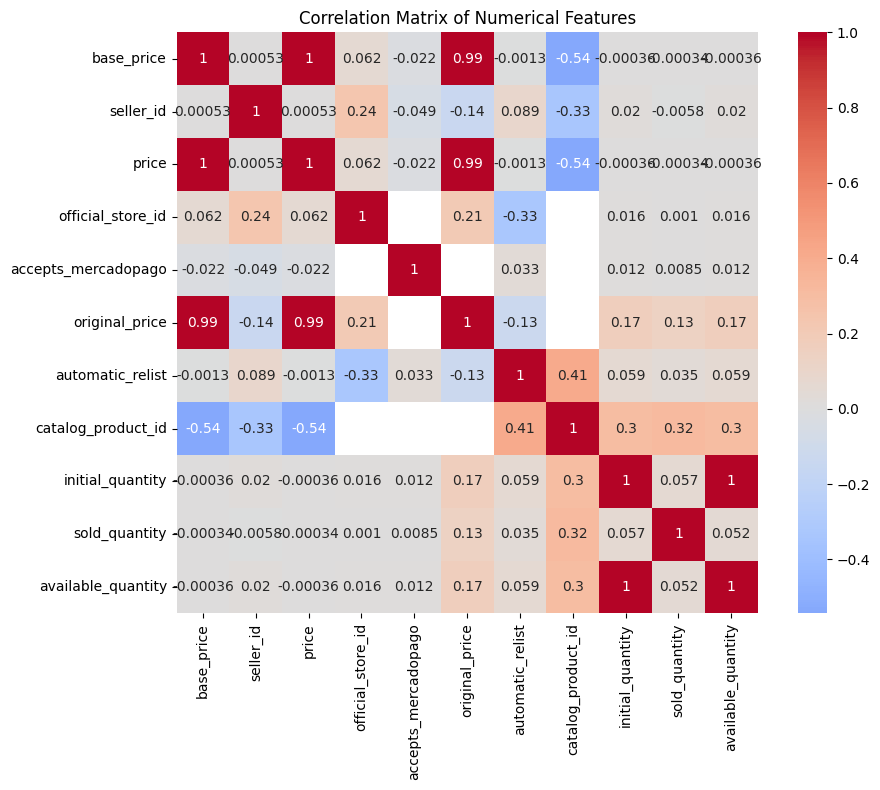


Highly correlated feature pairs (|correlation| > 0.7):
  base_price - price: 1.000
  base_price - original_price: 0.994
  price - original_price: 0.994
  initial_quantity - available_quantity: 1.000


In [31]:
# Correlation analysis for numerical features
if len(numerical_features) > 1:
    print("=== FEATURE CORRELATION ANALYSIS ===")
    
    # Create correlation matrix
    corr_matrix = df[numerical_features].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
    
    if high_corr_pairs:
        print("\nHighly correlated feature pairs (|correlation| > 0.7):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"  {feat1} - {feat2}: {corr:.3f}")
    else:
        print("\nNo highly correlated numerical features found.")
else:
    print("=== FEATURE CORRELATION ANALYSIS ===")
    print("Not enough numerical features for correlation analysis.")

## 9. Feature Engineering Opportunities

In [32]:
print("=== FEATURE ENGINEERING OPPORTUNITIES ===")

# Text-based features
if 'title' in df.columns:
    print("\n1. TEXT-BASED FEATURES:")
    print("   - Title length")
    print("   - Description length")
    print("   - Word count in title/description")
    print("   - Presence of specific keywords (new, usado, original, etc.)")
    print("   - TF-IDF features from title and description")
    print("   - Language detection")
    print("   - Sentiment analysis")

# Categorical features
if categorical_features:
    print("\n2. CATEGORICAL FEATURES:")
    print("   - One-hot encoding for low-cardinality features")
    print("   - Target encoding for high-cardinality features")
    print("   - Frequency encoding")
    
    for col in categorical_features:
        try:
            unique_count = df[col].nunique()
            if unique_count > 20:
                print(f"     * {col}: High cardinality ({unique_count} unique values) - consider target encoding")
            else:
                print(f"     * {col}: Low cardinality ({unique_count} unique values) - suitable for one-hot encoding")
        except:
            print(f"     * {col}: Cannot determine cardinality")

# Numerical features
if numerical_features:
    print("\n3. NUMERICAL FEATURES:")
    print("   - Standard scaling")
    print("   - Log transformation for skewed distributions")
    print("   - Binning for continuous variables")
    
    for col in numerical_features:
        try:
            skewness = df[col].skew()
            if abs(skewness) > 1:
                print(f"     * {col}: Skewed distribution (skewness: {skewness:.2f}) - consider log transformation")
            else:
                print(f"     * {col}: Normal distribution (skewness: {skewness:.2f})")
        except:
            print(f"     * {col}: Cannot calculate skewness")

# Complex features
if complex_features:
    print("\n4. COMPLEX FEATURES:")
    print("   - Extract specific fields from dictionaries")
    print("   - Count elements in lists")
    print("   - Extract nested information")
    
    for col in complex_features:
        print(f"     * {col}: Analyze structure and extract relevant information")

=== FEATURE ENGINEERING OPPORTUNITIES ===

1. TEXT-BASED FEATURES:
   - Title length
   - Description length
   - Word count in title/description
   - Presence of specific keywords (new, usado, original, etc.)
   - TF-IDF features from title and description
   - Language detection
   - Sentiment analysis

2. CATEGORICAL FEATURES:
   - One-hot encoding for low-cardinality features
   - Target encoding for high-cardinality features
   - Frequency encoding
     * condition: Low cardinality (2 unique values) - suitable for one-hot encoding
     * site_id: Low cardinality (1 unique values) - suitable for one-hot encoding
     * listing_type_id: Low cardinality (7 unique values) - suitable for one-hot encoding
     * buying_mode: Low cardinality (3 unique values) - suitable for one-hot encoding
     * listing_source: Low cardinality (1 unique values) - suitable for one-hot encoding
     * international_delivery_mode: Low cardinality (1 unique values) - suitable for one-hot encoding
     * di

## 10. Model Feature Recommendations

In [33]:
print("=== MODEL FEATURE RECOMMENDATIONS ===")

print("\nHIGH PRIORITY FEATURES:")
print("1. Title and Description - Most important for classification")
print("2. Price - Strong indicator of condition")
print("3. Category/Domain - Different categories may have different patterns")
print("4. Seller information - May indicate seller type")

print("\nMEDIUM PRIORITY FEATURES:")
print("1. Shipping information")
print("2. Location data")
print("3. Listing duration")
print("4. Image count")

print("\nLOW PRIORITY FEATURES:")
print("1. Complex nested data (extract specific fields if needed)")
print("2. High-cardinality categorical features (use target encoding)")
print("3. Features with high missing values")

print("\nFEATURE SELECTION STRATEGY:")
print("1. Start with text features (TF-IDF)")
print("2. Add numerical features with scaling")
print("3. Add low-cardinality categorical features")
print("4. Use feature selection techniques (SelectKBest, RFE)")
print("5. Consider ensemble methods for feature importance")

=== MODEL FEATURE RECOMMENDATIONS ===

HIGH PRIORITY FEATURES:
1. Title and Description - Most important for classification
2. Price - Strong indicator of condition
3. Category/Domain - Different categories may have different patterns
4. Seller information - May indicate seller type

MEDIUM PRIORITY FEATURES:
1. Shipping information
2. Location data
3. Listing duration
4. Image count

LOW PRIORITY FEATURES:
1. Complex nested data (extract specific fields if needed)
2. High-cardinality categorical features (use target encoding)
3. Features with high missing values

FEATURE SELECTION STRATEGY:
1. Start with text features (TF-IDF)
2. Add numerical features with scaling
3. Add low-cardinality categorical features
4. Use feature selection techniques (SelectKBest, RFE)
5. Consider ensemble methods for feature importance


## 11. Summary and Conclusions

In [34]:
print("=== SUMMARY AND CONCLUSIONS ===")

print(f"\nDATASET OVERVIEW:")
print(f"- Total samples: {len(df)}")
print(f"- Features: {len(df.columns)}")
print(f"- Target distribution: {dict(df['condition'].value_counts())}")

print(f"\nFEATURE BREAKDOWN:")
print(f"- Text features: {len(text_features)}")
print(f"- Numerical features: {len(numerical_features)}")
print(f"- Categorical features: {len(categorical_features)}")
print(f"- Complex features: {len(complex_features)}")

print(f"\nKEY INSIGHTS:")
print("1. Text features (title, description) are crucial for classification")
print("2. Price is likely a strong numerical predictor")
print("3. Category information may provide useful context")
print("4. Some features may need special handling (dictionaries, high cardinality)")

print(f"\nRECOMMENDED NEXT STEPS:")
print("1. Implement text preprocessing and TF-IDF vectorization")
print("2. Handle missing values appropriately")
print("3. Apply feature scaling for numerical features")
print("4. Use one-hot encoding for categorical features")
print("5. Extract useful information from complex features")
print("6. Implement feature selection to reduce dimensionality")
print("7. Test multiple algorithms and ensemble methods")

=== SUMMARY AND CONCLUSIONS ===

DATASET OVERVIEW:
- Total samples: 100000
- Features: 48
- Target distribution: {'new': np.int64(53758), 'used': np.int64(46242)}

FEATURE BREAKDOWN:
- Text features: 3
- Numerical features: 11
- Categorical features: 9
- Complex features: 14

KEY INSIGHTS:
1. Text features (title, description) are crucial for classification
2. Price is likely a strong numerical predictor
3. Category information may provide useful context
4. Some features may need special handling (dictionaries, high cardinality)

RECOMMENDED NEXT STEPS:
1. Implement text preprocessing and TF-IDF vectorization
2. Handle missing values appropriately
3. Apply feature scaling for numerical features
4. Use one-hot encoding for categorical features
5. Extract useful information from complex features
6. Implement feature selection to reduce dimensionality
7. Test multiple algorithms and ensemble methods
